In [57]:
%load_ext autoreload
%autoreload 2

import json
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
with open("../results/alignment_tax_v0.17.json", "r") as f:
# with open("../results/alignment_tax_v0.16.json", "r") as f:
    results = json.load(f)

In [74]:
results["meta"]

{'model_name': 'meta-llama/Llama-2-7b-chat-hf',
 'act_file_path': 'data/activations/acts_v0.7_Llama-2-7b-hf_1000.pt',
 'layer': 29,
 'batch_size': 2,
 'max_seq_length': 4096,
 'total_tokens_per_batch': 1000000,
 'injection_coefficients': [0, 1, 2, 5, 10, 20, 50, 100],
 'note': '',
 'mode': {}}

In [75]:
#TODO: really messy code, should work on changing the structuring of the results
accs = {}
modes = ("only_text", "only_code")
injection_coefficients = list(results["only_code"].keys())
metrics = ("top1_acc", "top10_acc", "skip50_top1_acc", "skip50_top10_acc")


for mode in modes:
    accs[mode] = {}
    for metric in metrics:
        accs[mode][metric] = [0]*len(injection_coefficients), [0]*len(injection_coefficients)
    
    for i, ic in enumerate(injection_coefficients):
        keys_batches = results[mode][ic].keys()
        for batch in keys_batches:
            for metric in metrics:
                accs[mode][metric][0][i] += results[mode][ic][batch][metric]
                accs[mode][metric][1][i] += 1

for mode in modes:
    for metric in metrics:
    # for metric in ["skip50_top10_acc"]:
        sum_scores, counts = accs[mode][metric]
        avg_scores = [sum_score / count for sum_score, count in zip(sum_scores, counts)]
        relative_scores = [avg_score / avg_scores[0]*100 for avg_score in avg_scores]
        accs[mode][metric] = relative_scores
        # print(f"\n\nMetric: {metric}")
        # print(f"avg_score: {avg_scores}\n")
        # print(f"relative_scores: {relative_scores}")

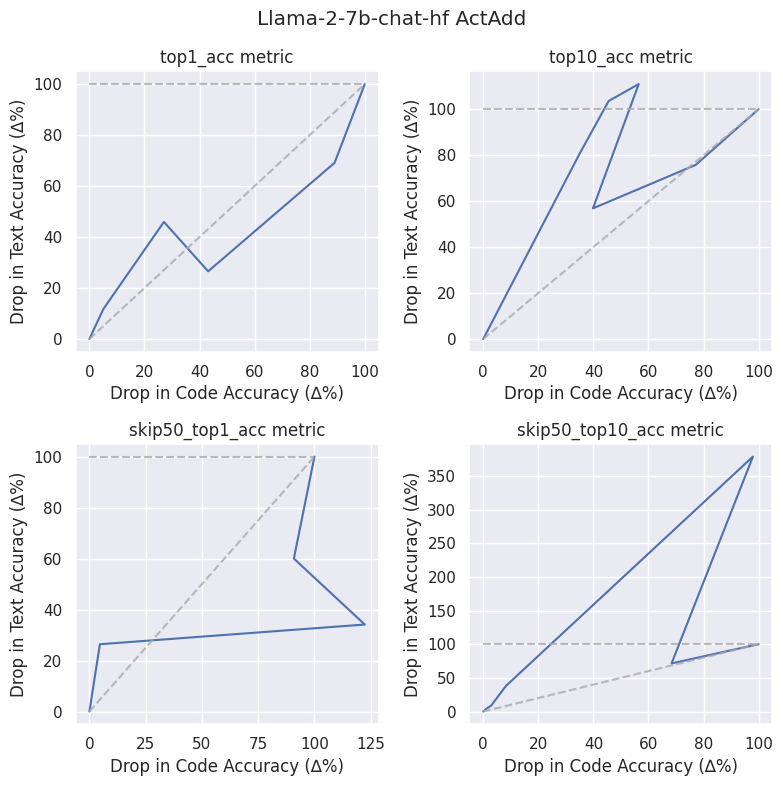

In [76]:
# create a seaborn style graph
sns.set_theme()

fig, axs = plt.subplots(2, 2, figsize=(8,8))
scale = 100

for metric, ax in zip(metrics, axs.reshape(-1)):
    ax.plot(accs["only_code"][metric], accs['only_text'][metric])
    ax.set_title(f"{metric} metric")
    ax.set_xlabel("Drop in Code Accuracy (∆%)")
    ax.set_ylabel("Drop in Text Accuracy (∆%)")

    ax.plot([0, scale], [scale, scale], color="darkgray", linestyle="--", alpha=0.8)
    ax.plot([0, scale], [0,     scale], color="darkgray", linestyle="--", alpha=0.8)

title = results["meta"]["model_name"].split("/")[1] + " ActAdd"
plt.suptitle(title)
fig.tight_layout()
plt.show()

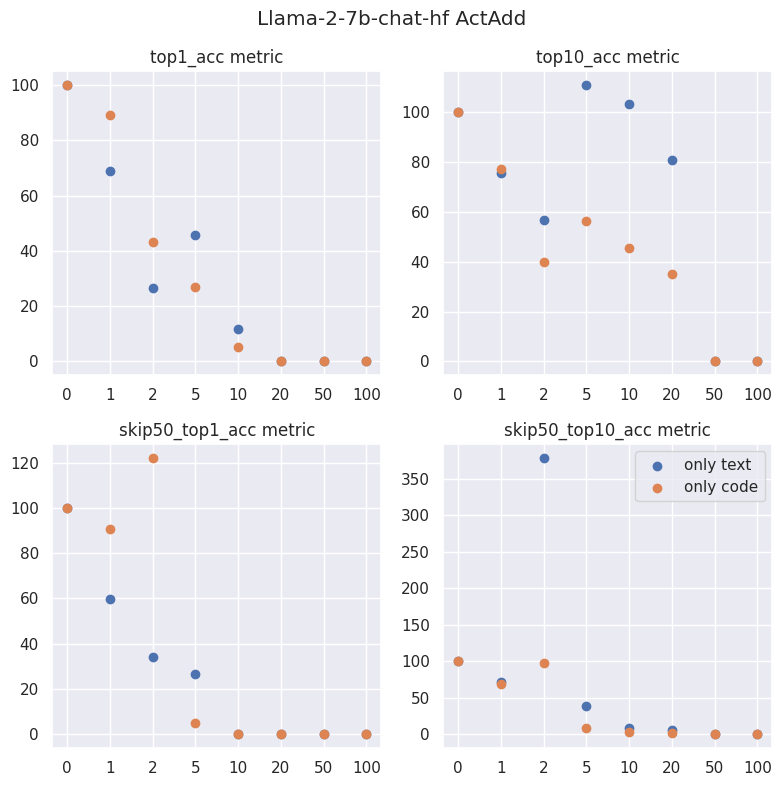

In [77]:
# create a seaborn style graph
sns.set_theme()
fig, axs = plt.subplots(2, 2, figsize=(8,8))
scale = 100
ic_ints = [ic.split("_")[2] for ic in injection_coefficients]

for metric, ax in zip(metrics, axs.reshape(-1)):
    # ax.scatter(accs["only_code"][metric], accs['only_text'][metric])
    ax.scatter(ic_ints, accs['only_text'][metric], label="only text")
    ax.scatter(ic_ints, accs['only_code'][metric], label="only code")

    ax.set_title(f"{metric} metric")
    # ax.set_xlabel("Drop in Code Accuracy (∆%)")
    # ax.set_ylabel("Drop in Text Accuracy (∆%)")

    # ax.plot([0, scale], [scale, scale], color="darkgray", linestyle="--", alpha=0.8)
    # ax.plot([0, scale], [0,     scale], color="darkgray", linestyle="--", alpha=0.8)
plt.legend()
plt.suptitle(title)
fig.tight_layout()
plt.show()

In [72]:
from utils import load_pile
from tqdm import tqdm
from time import sleep

In [56]:
1 - 0.1 / 0.2

0.5

In [53]:
total_tokens_per_batch = 1_0_000
batch_size = 2
layer = 29
injection_coefficients = (0, 1, 2, 5, 10, 20, 50, 100)

for mode in ("only_text", "only_code"):
    dataset = load_pile(split="train", mode=mode, batch_size=batch_size)
    # TODO: still test which values are best
    for ic in injection_coefficients:
        results[mode][f"injection_coefficient_{ic}"] = {}
        analyzed_tokens = 0
        batch_num = 0
        pbar = tqdm(total=total_tokens_per_batch)
        while analyzed_tokens < total_tokens_per_batch:
            # torch.cuda.empty_cache()
            pbar.update(analyzed_tokens)
            pbar.set_description(f"Mode: {mode} Injection Coefficient: {ic} Analyzed"
            )
            analyzed_tokens += 500
            sleep(0.5)

        pbar.close()

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Mode: only_text Injection Coefficient: 100 Analyzed: : 60000it [00:09, 6424.17it/s] 
Mode: only_text Injection Coefficient: 0 Analyzed: : 95000it [00:10, 8849.34it/s] 
Mode: only_text Injection Coefficient: 1 Analyzed: : 95000it [00:10, 9025.45it/s]                        
Mode: only_text Injection Coefficient: 2 Analyzed: : 95000it [00:10, 9076.58it/s]                        
Mode: only_text Injection Coefficient: 5 Analyzed: : 52500it [00:07, 11338.41it/s]                       

KeyboardInterrupt: 